In [122]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [123]:
window_sizes = [32, 64, 128, 256, 512, 1024] # 512 is around minute
z_score_threshold = 3
size_of_plot = 10000

In [124]:
df = pd.read_csv("data/finnhub7-12-2h.csv")
columns = ["price", "volume", "trade_ts"]
timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"
df = df[columns]
df["trade_ts"] = df["trade_ts"].apply(lambda x: datetime.strptime(x, timestamp_format))
df = df.set_index("trade_ts")

In [125]:
print(df.describe())
print(df.info())

              price        volume
count  42099.000000  42099.000000
mean   99538.125663      0.011681
std      106.882313      0.051490
min    99336.000000      0.000010
25%    99461.020000      0.000150
50%    99514.820000      0.000390
75%    99624.000000      0.002660
max    99800.000000      2.865890
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42099 entries, 2024-12-07 14:35:31.060000+00:00 to 2024-12-07 15:59:39.554000+00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   42099 non-null  float64
 1   volume  42099 non-null  float64
dtypes: float64(2)
memory usage: 986.7 KB
None


C:\Users\seksc\Documents\sem7\anomaly-detection\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


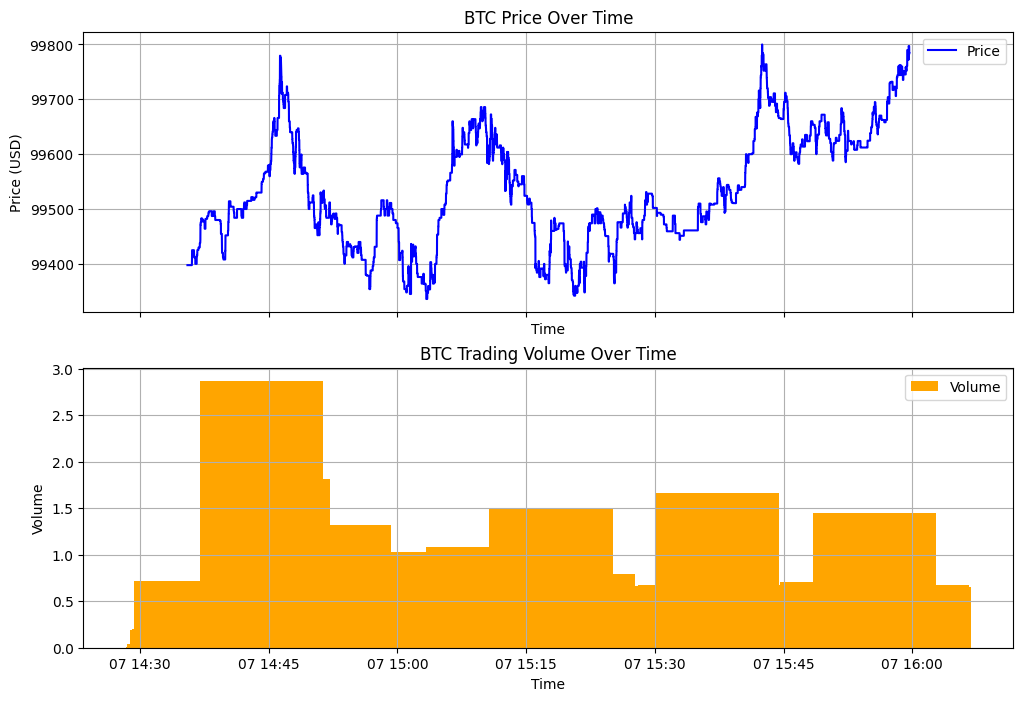

In [126]:
# Plot Price and Volume
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Price
ax[0].plot(df.index, df["price"], label="Price", color="blue", linewidth=1.5)
ax[0].set_title("BTC Price Over Time")
ax[0].set_ylabel("Price (USD)")
ax[0].set_xlabel("Time")
ax[0].grid(True)
ax[0].legend()

# Plot Volume
ax[1].bar(df.index, df["volume"], label="Volume", color="orange", width=0.01)
ax[1].set_title("BTC Trading Volume Over Time")
ax[1].set_ylabel("Volume")
ax[1].set_xlabel("Time")
ax[1].grid(True)
ax[1].legend()

# Adjust layout and show the plots
# plt.tight_layout()
plt.show()



In [127]:
# Function to calculate rolling Z-score
def detect_anomalies(dataframe, column, window_size, threshold):
    rolling_mean = dataframe[column].rolling(window=window_size).mean()
    rolling_std = dataframe[column].rolling(window=window_size).std()
    z_scores = (dataframe[column] - rolling_mean) / rolling_std
    anomalies = np.abs(z_scores) > threshold
    return anomalies

{'price': np.int64(2330), 'volume': np.int64(1635)}
{'price': np.int64(2512), 'volume': np.int64(1332)}
{'price': np.int64(2376), 'volume': np.int64(1083)}
{'price': np.int64(1849), 'volume': np.int64(926)}
{'price': np.int64(1427), 'volume': np.int64(871)}
{'price': np.int64(1020), 'volume': np.int64(790)}


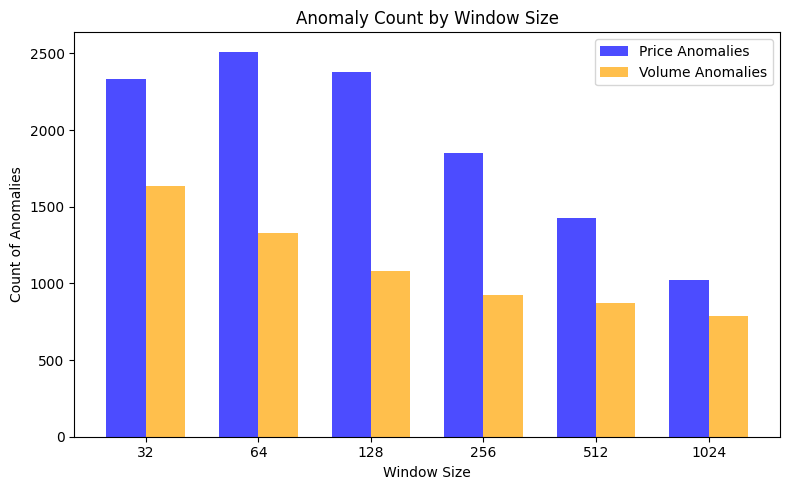

In [128]:
# Apply anomaly detection for each window size
anomalies_summary = {}

for window in window_sizes:
    anomalies_price = detect_anomalies(df, 'price', window, z_score_threshold)
    anomalies_volume = detect_anomalies(df, 'volume', window, z_score_threshold)
    
    # Count anomalies
    anomalies_count = {
        'price': anomalies_price.sum(),
        'volume': anomalies_volume.sum()
    }
    anomalies_summary[window] = anomalies_count
    print(anomalies_count)

# Extract data for plotting
window_sizes = list(anomalies_summary.keys())
price_anomalies = [anomalies_summary[window]['price'] for window in window_sizes]
volume_anomalies = [anomalies_summary[window]['volume'] for window in window_sizes]

# Set up the bar chart
x = np.arange(len(window_sizes))  # x positions for groups
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(8, 5))

# Plot price anomalies
ax.bar(x - width/2, price_anomalies, width, label='Price Anomalies', color='blue', alpha=0.7)

# Plot volume anomalies
ax.bar(x + width/2, volume_anomalies, width, label='Volume Anomalies', color='orange', alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel('Window Size')
ax.set_ylabel('Count of Anomalies')
ax.set_title('Anomaly Count by Window Size')
ax.set_xticks(x)
ax.set_xticklabels(window_sizes)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()

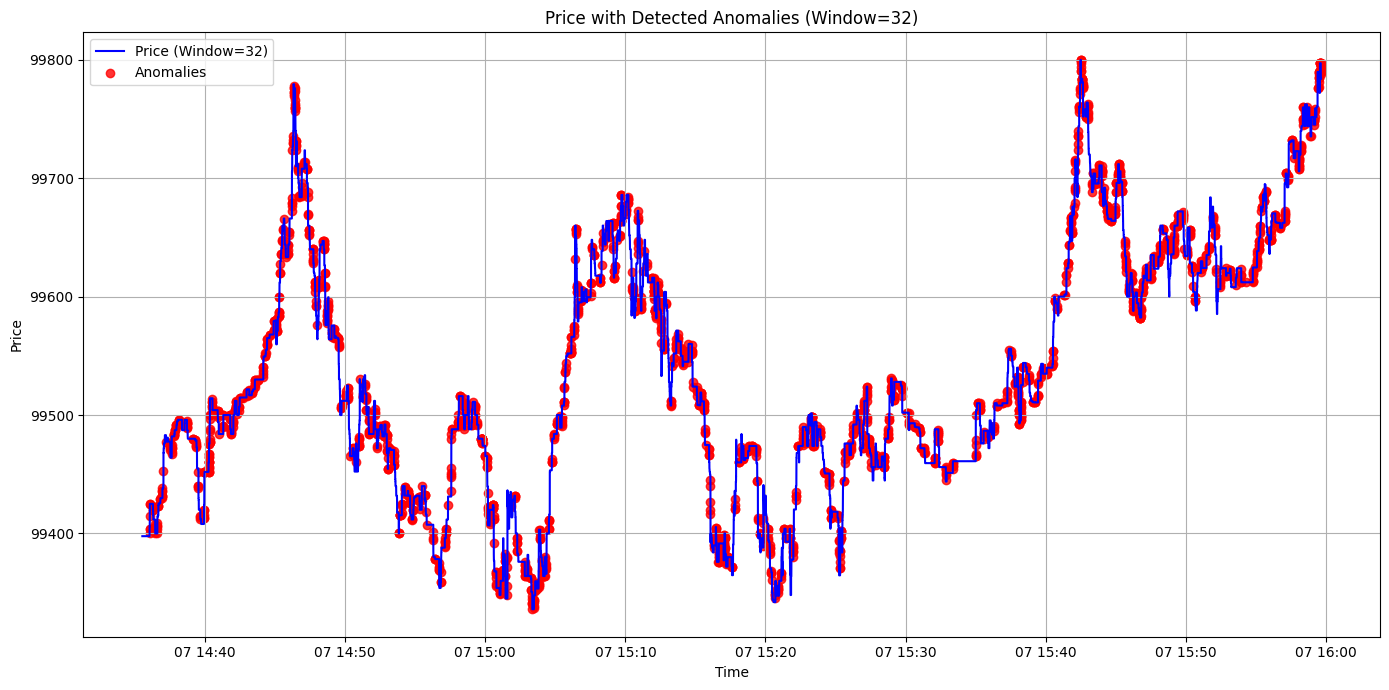

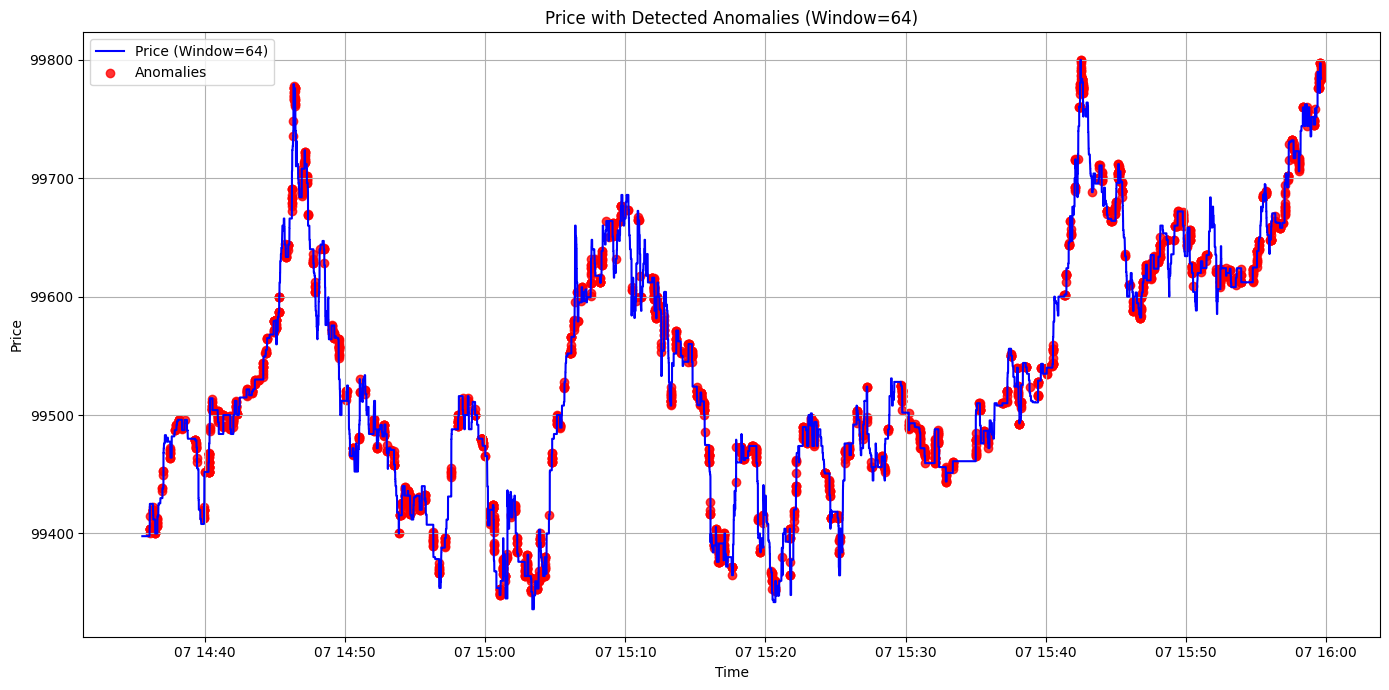

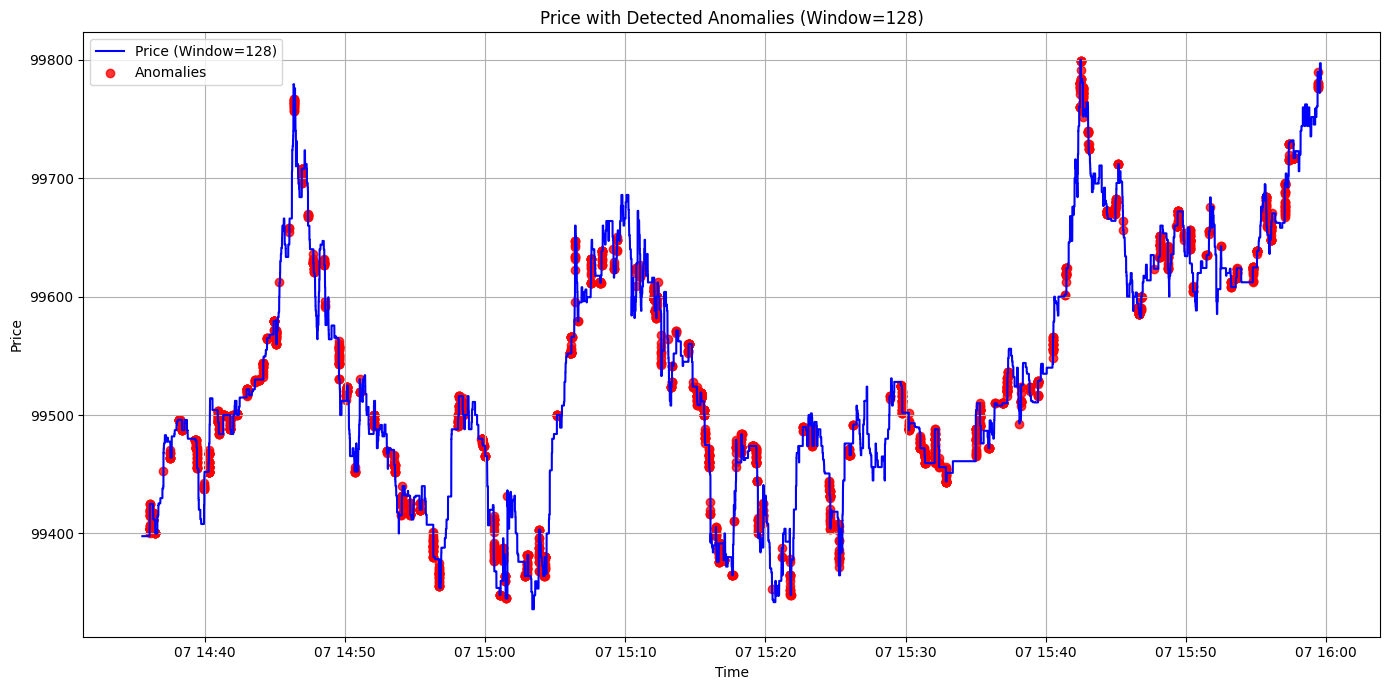

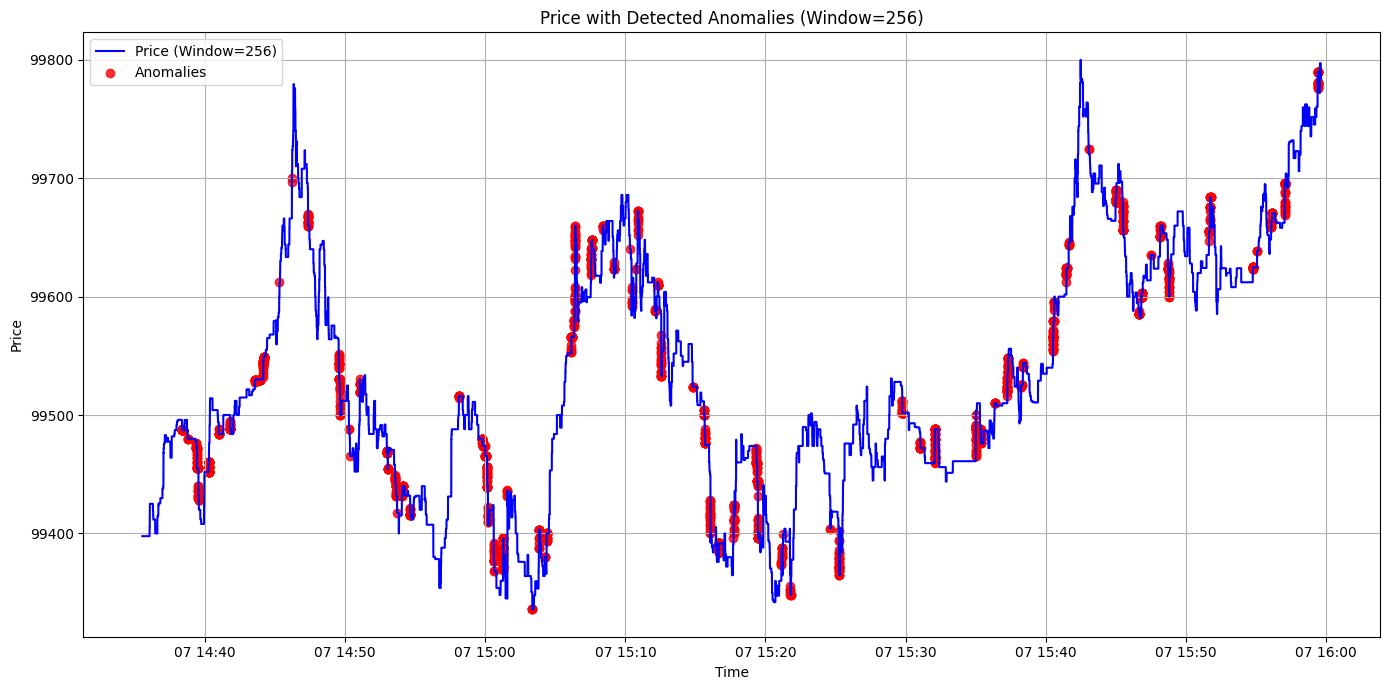

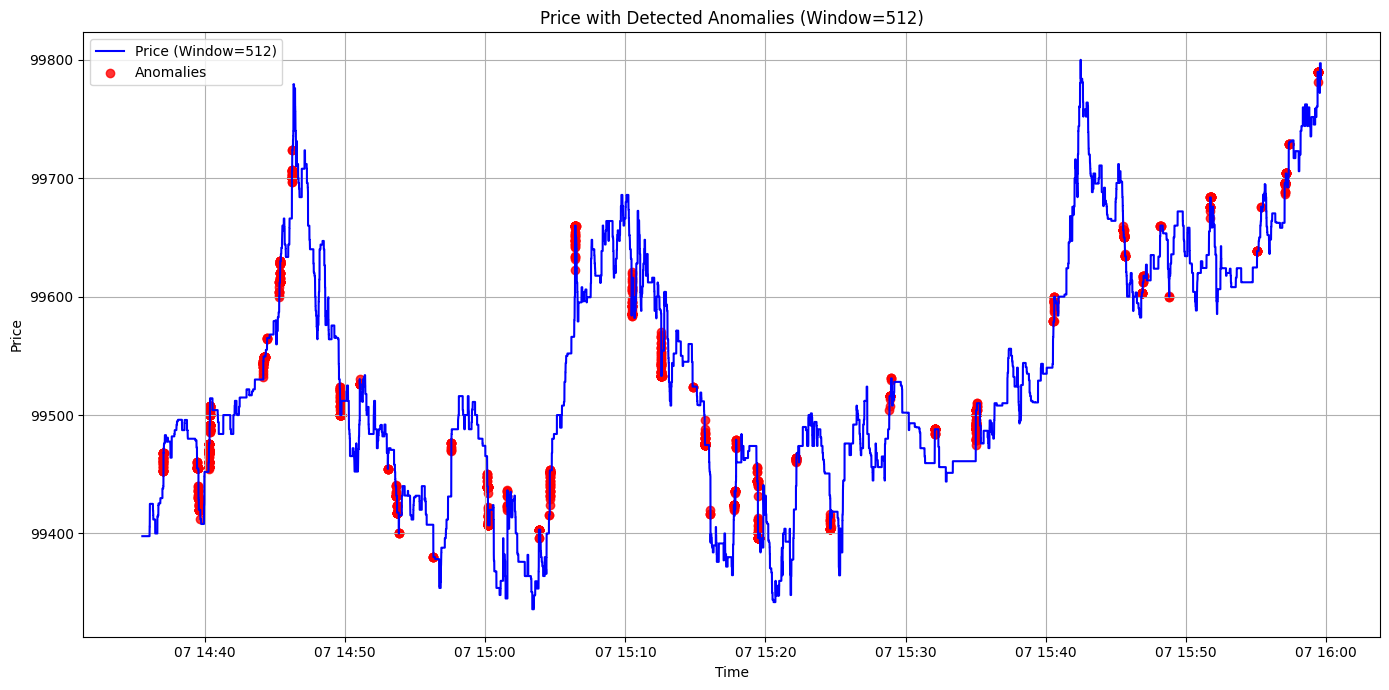

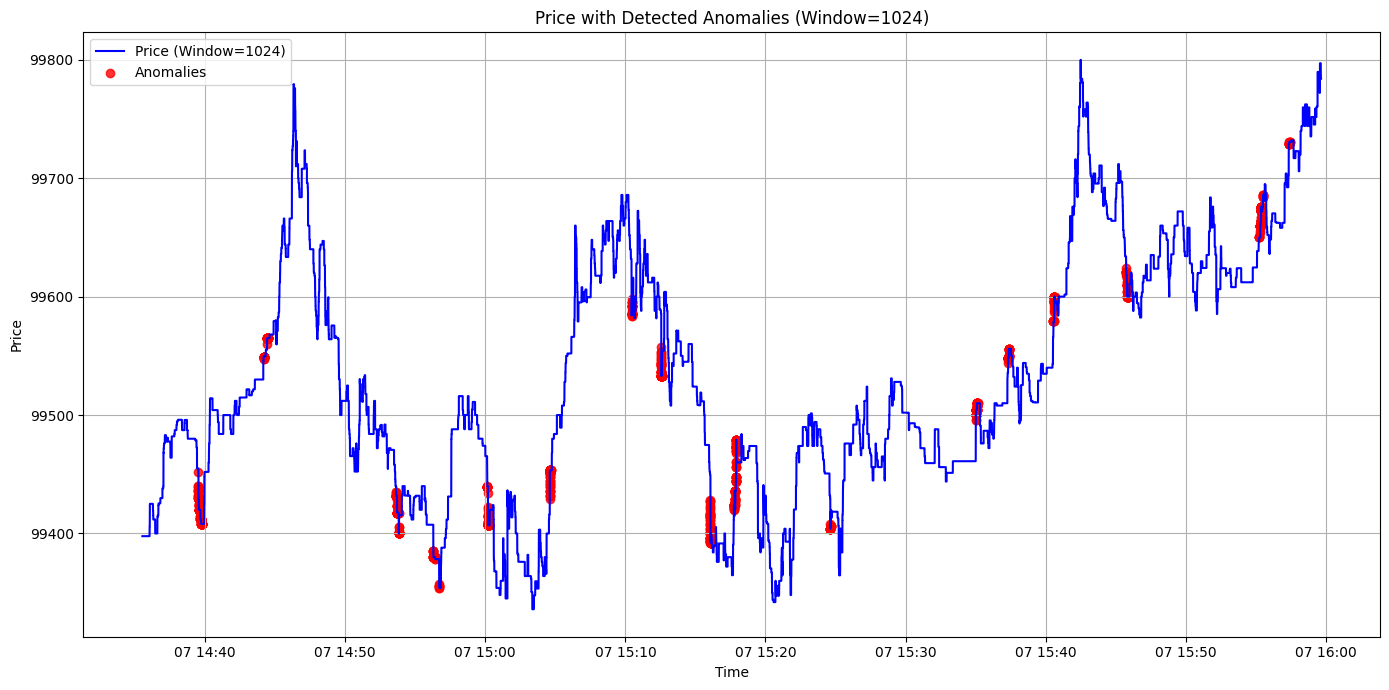

In [129]:
stats_table = []
def plot_anomalies_per_window(df, column, window_sizes, z_score_threshold):
    for window_size in window_sizes:
        # Detect anomalies
        anomalies = detect_anomalies(df, column, window_size, z_score_threshold)
        anomaly_points = df[column][anomalies]  # Get anomaly values
        stat = f"Anomaly Count for {window_size}: {len(anomaly_points)};  {int(len(anomaly_points)/len(df)*100)}%"
        stats_table.append(stat)
        # Plot the original data with anomalies
        plt.figure(figsize=(14, 7))
        plt.plot(df.index, df[column], label=f'{column.capitalize()} (Window={window_size})', color='blue', linewidth=1.5)
        plt.scatter(anomaly_points.index, anomaly_points, label=f'Anomalies', color='red', alpha=0.8)
        
        # Add plot details
        plt.title(f"{column.capitalize()} with Detected Anomalies (Window={window_size})")
        plt.xlabel("Time")
        plt.ylabel(column.capitalize())
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Example usage: Create separate plots for each window size
plot_anomalies_per_window(df, "price", window_sizes, z_score_threshold)



In [130]:
vs = []
for t in stats_table:
    print(t)
    v = int(t.split(";")[1].strip().split("%")[0])
    vs.append(v)
print(f"The average percent of anomalies per different windows is {sum(vs)/len(vs):.2f}% of the total")


Anomaly Count for 32: 2330;  5%
Anomaly Count for 64: 2512;  5%
Anomaly Count for 128: 2376;  5%
Anomaly Count for 256: 1849;  4%
Anomaly Count for 512: 1427;  3%
Anomaly Count for 1024: 1020;  2%
The average percent of anomalies per different windows is 4.00% of the total


# For finnhub 2h 6.12.2024
Anomaly Count for 32: 3157;  5%
Anomaly Count for 64: 3312;  5%
Anomaly Count for 128: 2752;  4%
Anomaly Count for 256: 1819;  3%
Anomaly Count for 512: 1528;  2%
Anomaly Count for 1024: 1611;  2%
The average percent of anomalies per different windows is 3.50% of the total